<a href="https://colab.research.google.com/github/TropMol/TropMol-Boitata/blob/main/ProjectB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beta project

Boitatá module (AChE inhibitors predictor)

Developed by: Thiago H. Döring

**Bugs**
- If you encounter any bugs, please report the issue to thiago.doring@ufsc.br

v. 1.0

# Libraries and packages

The main packages are:

1. RdKit (www....)

X. ChEMBL (www..) Current Release: ChEMBL 33
Provided under a [Creative Commons Attribution-ShareAlike 3.0 Unported license](https://https://creativecommons.org/licenses/by-sa/3.0/), [ChEMBL 1](https://https://doi.org/10.1093/nar/gkad1004), [ChEMBL 2](https://doi.org/10.1093/nar/gkv352).

In [ ]:
#@title Install libraries and packages

!pip install rdkit-pypi
!sudo apt-get install python3-rdkit
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install scikit-learn chembl_webresource_client pandas
!pip install matplotlib
!pip install seaborn

!pip install scikit-optimize


Optional libraries and packages

In [ ]:
#@title Import libraries and packages
%%capture
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.svm import SVR
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from chembl_webresource_client.new_client import new_client
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform, reciprocal


from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

#normalizacao
from sklearn.preprocessing import StandardScaler

# FragFp descriptor calculation by RDkit

In [ ]:
#@title FragFp descriptor
%%capture
def calculate_fragfp(molecule):
    mol = Chem.MolFromSmiles(molecule['canonical_smiles'])
    fragfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return list(fragfp)

# Get ChEMBL data for human AChE

In [ ]:
#@title ChEMBLdb
%%capture
target = new_client.target
target_query = target.search('acetylcholinesterase')
acetylcholinesterase = target_query[0]

activity = new_client.activity
activity_query = activity.filter(target_chembl_id=acetylcholinesterase['target_chembl_id'], standard_type="IC50")

# Extract SMILES and IC50 values

In [ ]:
#@title SMILES and IC50
#@markdown It will take some minutes, Please, drink water &#x1F4A6; and wait.
%%capture
data = [{'canonical_smiles': entry['canonical_smiles'], 'ic50': entry['value']} for entry in activity_query]

In [ ]:
#@title DataFrame
%%capture
df = pd.DataFrame(data)

In [ ]:
#@title Cleaning DataFrame
%%capture
df.dropna(inplace=True)

# Creating SVM Model
Criar conjunto de dados de treino

In [ ]:
#@title Create a training DataSet
%%capture
X_train = [calculate_fragfp(molecule) for _, molecule in df.dropna().iterrows()]
y_train = df['ic50'].astype(float).dropna()

In [ ]:
#@title Checking DataFrame
%%capture
print(len(X_train), len(y_train))

In [ ]:
display(df)

,canonical_smiles,ic50
0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,0.75
1,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,0.1
2,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50.0
3,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,0.3
4,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,0.8
...,...,...
8827,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,274.0
8828,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,76.2
8829,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,55.0
8830,Nc1c2c(nc3ccccc13)CCCC2,1.18


# Training SVM Model



In [ ]:
#@title OTIMIZAÇÃO DE PARAMETROS GERAL
# Defina a grade de parâmetros que deseja explorar
param_dist = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': reciprocal(0.001, 1000),  # Distribuição recíproca para C
    'gamma': uniform(0.001, 10),  # Distribuição uniforme para gamma
    'degree': [2, 3, 4, 5],  # Grau do polinômio
    'coef0': [-1, 0, 1, 2]  # Termo independente em kernels sigmoidais e polinomiais
}

# Crie uma instância do modelo SVM
svm_model = SVR()

# Crie uma instância do RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_dist, n_iter=1, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

# Ajuste o modelo aos dados de treinamento
random_search.fit(X_train, y_train)

# Visualize os melhores parâmetros
print("Melhores Parâmetros Encontrados:")
print(random_search.best_params_)

# Obtenha o melhor modelo treinado
best_svm_model = random_search.best_estimator_


In [ ]:
#@title OTIMIZAÇÃO DE PARAMETROS EXCLUSIVA PARA KERNEL LINEAR
# Defina a grade de parâmetros apenas para o kernel linear
param_dist_linear = {
    'C': reciprocal(0.001, 1000),  # Distribuição recíproca para C
}

# Crie uma instância do modelo SVM com kernel linear
svm_model_linear = SVR(kernel='linear')

# Crie uma instância do RandomizedSearchCV apenas para o kernel linear
random_search_linear = RandomizedSearchCV(
    svm_model_linear, param_distributions=param_dist_linear, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

# Ajuste o modelo aos dados de treinamento
random_search_linear.fit(X_train, y_train)

# Visualize os melhores parâmetros para o kernel linear
print("Melhores Parâmetros Encontrados para o Kernel Linear:")
print(random_search_linear.best_params_)

# Obtenha o melhor modelo treinado com kernel linear
best_svm_model_linear = random_search_linear.best_estimator_

In [ ]:
#@title OTIMIZAÇÃO DE PARAMETROS SEM O KERNEL RBF
# Defina a grade de parâmetros que deseja explorar
param_dist = {
    'kernel': ['linear', 'poly', 'sigmoid'],  # Remova 'rbf' da lista de kernels
    'C': reciprocal(0.001, 1000),  # Distribuição recíproca para C
    'gamma': uniform(0.001, 10),  # Distribuição uniforme para gamma
    'degree': [2, 3, 4, 5],  # Grau do polinômio
    'coef0': [-1, 0, 1, 2]  # Termo independente em kernels sigmoidais e polinomiais
}

# Crie uma instância do modelo SVM
svm_model = SVR()

# Crie uma instância do RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

# Ajuste o modelo aos dados de treinamento
random_search.fit(X_train, y_train)

# Visualize os melhores parâmetros
print("Melhores Parâmetros Encontrados:")
print(random_search.best_params_)

# Obtenha o melhor modelo treinado
best_svm_model = random_search.best_estimator_

In [ ]:
#@title Kernel configs
#@markdown It will take a few minutes. Have you drink water?
%%capture
#svm_model = SVR(kernel='linear', C=44.750401913509016) # n = 100
#svm_model = SVR(kernel='linear', C=0.1767016940294795, gamma=4.390714207056361, degree=4, coef0=-1)
svm_model = SVR(kernel='poly', C=4.418441521199722, gamma=0.6515159298527952, degree=2, coef0=-1)
svm_model.fit(X_train, y_train)


In [ ]:
#@title Predict IC50 for all training set
%%capture
y_pred_train = svm_model.predict(X_train)

In [ ]:
#@title Residues (OPTIONAL)
residuos = y_train - y_pred_train

# Calcular o RMSD dos resíduos
rmsd_residuos = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Imprimir o valor do RMSD dos resíduos
print(f"RMSD dos Resíduos: {rmsd_residuos:.4f}")


RMSD dos Resíduos: 28617.2657


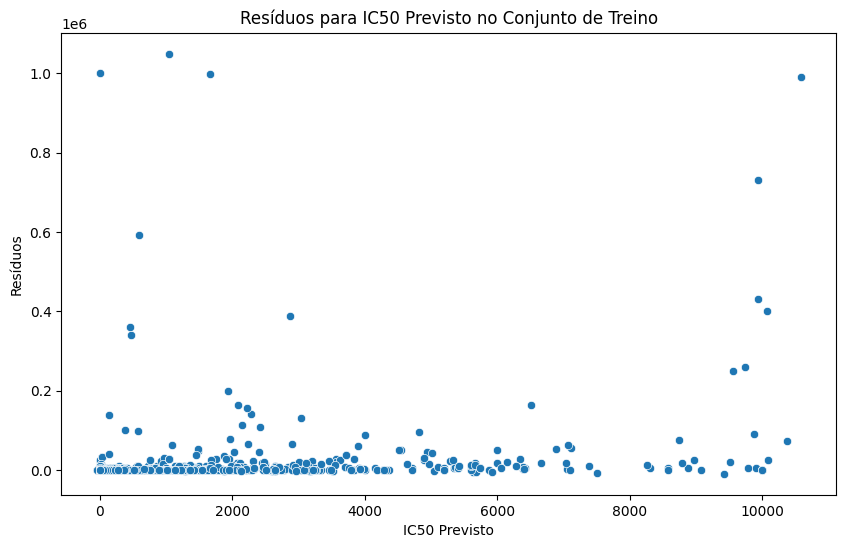

In [ ]:
# Plotar os resíduos (OPTIONAL)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_train, y=residuos)
plt.title('Resíduos para IC50 Previsto no Conjunto de Treino')
plt.xlabel('IC50 Previsto')
plt.ylabel('Resíduos')
plt.show()


In [ ]:
#OPTIONAL
print("Valores Observados (y_train):")
print(y_train)

print("\nValores Previstos (y_pred_train):")
print(y_pred_train)

Valores Observados (y_train):
0         0.75
1         0.10
2        50.00
3         0.30
4         0.80
         ...  
8827    274.00
8828     76.20
8829     55.00
8830      1.18
8831      5.40
Name: ic50, Length: 7547, dtype: float64

Valores Previstos (y_pred_train):
[6.49769741e-01 3.58601606e-04 5.00997682e+01 ... 5.50997439e+01
 7.04498945e+00 5.50008874e+00]


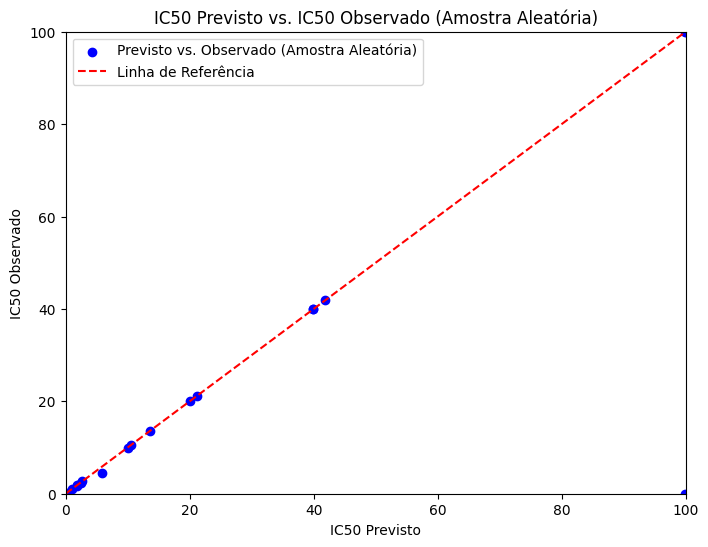

In [ ]:
#@title test serie (OPTIONAL)
# Selecionar 30 amostras aleatórias
indices_aleatorios = np.random.choice(len(y_train), size=30, replace=False)
y_train_amostra = y_train.iloc[indices_aleatorios]
y_pred_amostra = y_pred_train[indices_aleatorios]

# Criar um gráfico de dispersão com as amostras selecionadas
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_amostra, y_train_amostra, color='blue', label='Previsto vs. Observado (Amostra Aleatória)')
plt.plot([0, 200], [0, 200], linestyle='--', color='red', label='Linha de Referência')

# Definir intervalo desejado para os eixos X e Y
intervalo_x = [0, 100]
intervalo_y = [0, 100]

# Aplicar o intervalo aos eixos X e Y
plt.xlim(intervalo_x)
plt.ylim(intervalo_y)

# Adicionar rótulos e título ao gráfico
plt.xlabel('IC50 Previsto')
plt.ylabel('IC50 Observado')
plt.title('IC50 Previsto vs. IC50 Observado (Amostra Aleatória)')

# Adicionar uma legenda
plt.legend()

# Exibir o gráfico
plt.show()


In [ ]:
#OPTIONAL
# Criar DataFrame com as amostras selecionadas
tabela = pd.DataFrame({'y_train': y_train_amostra, 'y_pred_train': y_pred_amostra})

# Exibir a tabela
print(tabela)

        y_train  y_pred_train
7791   1000.000   1000.101342
8597     40.000     39.899896
7466      2.320      2.420416
8799     20.000     20.099948
5864   1175.000   1175.100035
2375     42.000     41.900478
965     290.000    134.099955
6335    802.400    802.500435
8658      2.800      2.699936
1743   3832.000   3831.900137
262      10.000     10.099695
2994      0.009     99.900882
54    20000.000   2074.052413
7762      1.700      1.800053
2121     40.000     39.900010
1037      1.780      1.880209
5018     21.100     21.200385
8630      0.136      0.235502
2986      0.300    260.099972
295     100.000    100.099499
1293      0.950      1.049771
4953    216.000    163.456252
7332     10.500     10.600097
1303  19580.000   2444.418030
4365     13.640     13.539549
5582    100.000     99.899770
1436      0.008      0.104164
2863    191.100    191.200069
6980   1460.000   1147.252329
2577      4.400      5.903271


In [ ]:
#@title NOVA TABELA (OPTIONAL)
# Calcular a nova coluna
pIC50_pred = -np.log((y_pred_amostra)/1000000)
pIC50_train = -np.log((y_train_amostra)/1000000)

# Calcular o R² para y_pred_amostra
r2_pred = r2_score(y_train_amostra, y_pred_amostra)

# Criar DataFrame com as amostras selecionadas e a nova coluna
tabela = pd.DataFrame({'y_train': y_train_amostra, 'y_pred_train': y_pred_amostra, 'pIC50_train': pIC50_train, 'pIC50_pred': pIC50_pred})

# Calcular o R² para y_pred_amostra
r2_pred = r2_score(y_train_amostra, y_pred_amostra)

# Imprimir o valor de R²
print(f"Coeficiente de Determinação (R²) para y_pred_amostra: {r2_pred:.4f}")

# Exibir a tabela
print(tabela)

Coeficiente de Determinação (R²) para y_pred_amostra: 0.1497
        y_train  y_pred_train  pIC50_train  pIC50_pred
7791   1000.000   1000.101342     6.907755    6.907654
8597     40.000     39.899896    10.126631   10.129137
7466      2.320      2.420416    12.973943   12.931571
8799     20.000     20.099948    10.819778   10.814793
5864   1175.000   1175.100035     6.746487    6.746402
2375     42.000     41.900478    10.077841   10.080213
965     290.000    134.099955     8.145630    8.916925
6335    802.400    802.500435     7.127903    7.127778
8658      2.800      2.699936    12.785891   12.822282
1743   3832.000   3831.900137     5.564368    5.564394
262      10.000     10.099695    11.512925   11.503005
2994      0.009     99.900882    18.526041    9.211332
54    20000.000   2074.052413     3.912023    6.178251
7762      1.700      1.800053    13.284882   13.227694
2121     40.000     39.900010    10.126631   10.129134
1037      1.780      1.880209    13.238897   13.184128
5018

In [ ]:
#@title MSE (ERRO QUADRÁTICO MÉDIO)
# Avaliar o modelo no conjunto de teste
y_pred = best_svm_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Erro Quadrático Médio (MSE) no conjunto de teste:", mse)

# Exibir a previsão (uM)

In [ ]:
# @title Texto de título predefinido
# Função para prever IC50 e pIC50 com base no SMILES inserido
def calculate_fragfp(molecule):
    mol = Chem.MolFromSmiles(molecule)
    if mol is not None:
        fragfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        return list(fragfp)
    else:
        return None

def prever_ic50_e_pic50(smiles):
    descritor = calculate_fragfp(smiles)

    if descritor is not None:
        ic50_predito = svm_model.predict([descritor])[0]
        pic50_predito = -np.log10(ic50_predito / 1e6)  # Cálculo do pIC50

        print(f'IC50 previsto para a molécula inserida: {ic50_predito}')
        print(f'pIC50 previsto para a molécula inserida: {pic50_predito}')

        # Mensagem adicional
        print("ProjectB can predict incorrect values. It's recommended use pIC50 values for better comparative relationships between theoretical and experimental activities")
    else:
        print('Erro: Falha na criação da molécula.')

# Widget para inserção do SMILES
widget_smiles = widgets.Text(description='Insira o SMILES:')
display(widget_smiles)

# Botão para acionar a previsão
botao_prever = widgets.Button(description='Prever IC50 e pIC50')

# Função chamada ao clicar no botão
def on_botao_prever_click(b):
    smiles_inserido = widget_smiles.value
    prever_ic50_e_pic50(smiles_inserido)

# Conectar a função ao evento de clique do botão
botao_prever.on_click(on_botao_prever_click)
display(botao_prever)

Text(value='', description='Insira o SMILES:')

Button(description='Prever IC50 e pIC50', style=ButtonStyle())

IC50 previsto para a molécula inserida: 64.23044149491646
pIC50 previsto para a molécula inserida: 4.192259092805345
ProjectB can predict incorrect values. It's recommended use pIC50 values for better comparative relationships between theoretical and experimental activities
IC50 previsto para a molécula inserida: 1060.9936331679817
pIC50 previsto para a molécula inserida: 2.9742872222139365
ProjectB can predict incorrect values. It's recommended use pIC50 values for better comparative relationships between theoretical and experimental activities
IC50 previsto para a molécula inserida: 144.35064747125242
pIC50 previsto para a molécula inserida: 3.8405812637918406
ProjectB can predict incorrect values. It's recommended use pIC50 values for better comparative relationships between theoretical and experimental activities
IC50 previsto para a molécula inserida: 608.703122976684
pIC50 previsto para a molécula inserida: 3.215594470075377
ProjectB can predict incorrect values. It's recommended

In [ ]:
#@title previsão simplificada
# Modifique a função calculate_fragfp para lidar com a criação da molécula
def calculate_fragfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fragfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        return list(fragfp)
    else:
        return None

# Exemplo: prever IC50 para a nova molécula fictícia
nova_molecula_smiles = 'COc1ncc(cn1)C(=O)N1C[C@@H]2CCN(C)[C@@H]2C1'
nova_molecula_descritor = calculate_fragfp(nova_molecula_smiles)

# Verifique se a molécula foi criada corretamente antes de prosseguir
if nova_molecula_descritor is not None:
    ic50_nova_molecula_predito = svm_model.predict([nova_molecula_descritor])[0]
    print(f'IC50 previsto para a nova molécula fictícia: {ic50_nova_molecula_predito}')
else:
    print('Erro: Falha na criação da molécula.')

IC50 previsto para a nova molécula fictícia: 114.79953291489667
